In [2]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm

# 8 The Lapped Bi-orthogonal Transform (LBT)

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [3]:
# X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X, _ = load_mat_img(img='bridge.mat', img_info='X')
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [4]:
from cued_sf2_lab.lbt import pot_ii


Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

In [5]:
from cued_sf2_lab.dct import regroup
from cued_sf2_lab.laplacian_pyramid import bpp, quantise
from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.lbt import pot_ii
C8 = dct_ii(8)
N = 8


# Pre-filtering and Post-filtering
Pf, Pr = pot_ii(N)
t = np.s_[N//2:-N//2]
Xp = X.copy()
Xp[t,:] = colxfm(Xp[t,:],Pf)
Xp[:,t] = colxfm(Xp[:,t].T,Pf).T
Y = colxfm(colxfm(Xp, C8).T, C8).T
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

Zp = Z.copy()
Zp[:,t] = colxfm(Zp[:,t].T,Pr.T).T
Zp[t,:] = colxfm(Zp[t,:],Pr.T)
reconstruction_error = np.max(np.abs(Zp - X))
if reconstruction_error < 1e-5:
    print("Reconstruction is successful: Zp matches X")
else:
    print("Reconstruction failed: Zp does not match X")

Reconstruction is successful: Zp matches X


## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

In [6]:
from cued_sf2_lab.laplacian_pyramid import bpp, quantise

import numpy as np

def lbt(X, s, N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    t = np.s_[N//2:-N//2]
    Xp = X.copy()
    Xp[t, :] = colxfm(Xp[t, :], Pf)
    Xp[:, t] = colxfm(Xp[:, t].T, Pf).T
    Y = colxfm(colxfm(Xp, C).T, C).T
    return Y

def undo(Z,s,N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    Zp = Z.copy()
    Zp[:,t] = colxfm(Zp[:,t].T,Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:],Pr.T)
    return Zp

def optimize_step_size(X, N, max_iteration, tol=1e-5):
    scaling_factors = np.arange(1.0, 2.1, 0.1)
    C = dct_ii(N)
    optimal_step_sizes = []

    for s in scaling_factors:
        errors = []
        attempted_sizes = np.arange(0, 2560) / 10

        for n in attempted_sizes:
            Y = lbt(X, s, N)
            Yq = quantise(Y, n)
            Z = colxfm(colxfm(Yq.T, C.T).T, C.T)
            Zp = undo(Z,s,N)
            X_q = quantise(X, 17)
            err_z = np.std(X - Zp)
            err_x = np.std(X_q - X)
            diff = np.abs(err_z - err_x)
            errors.append(diff)

        optimal_step_size = attempted_sizes[np.argmin(errors)]
        optimal_step_sizes.append(optimal_step_size)

    return optimal_step_sizes

# X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
# X = X - 128.0
# N = 8
# optimal_step_sizes = optimize_step_size(X, N=8, max_iteration=100, tol=1e-5)
print(optimize_step_size(X,N=8, max_iteration=100, tol=1e-5))



[17.9, 18.4, 18.7, 19.0, 19.2, 19.4, 19.6, 19.7, 19.8, 19.8, 19.9]


In [5]:

def undo(Z,s,N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    Zp = Z.copy()
    Zp[:,t] = colxfm(Zp[:,t].T,Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:],Pr.T)
    return Zp


In [41]:
def undo(Z, s, N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    t = np.s_[N//2:-N//2]
    Zp = Z.copy()
    Zp[:, t] = colxfm(Zp[:, t].T, Pr.T).T
    Zp[t, :] = colxfm(Zp[t, :], Pr.T)
    Xp = colxfm(colxfm(Zp, C.T).T, C.T)
    return Xp


In [6]:
def dctbpp(Yr,N):
    sub_images = Yr.reshape(N,256//N,N,256//N).swapaxes(1,2)
    total_bits = 0
    for i in range(sub_images.shape[0]):
        for j in range(sub_images.shape[1]):
            Ys = sub_images[i][j]
            total_bits += bpp(Ys)*Ys.size
    return total_bits

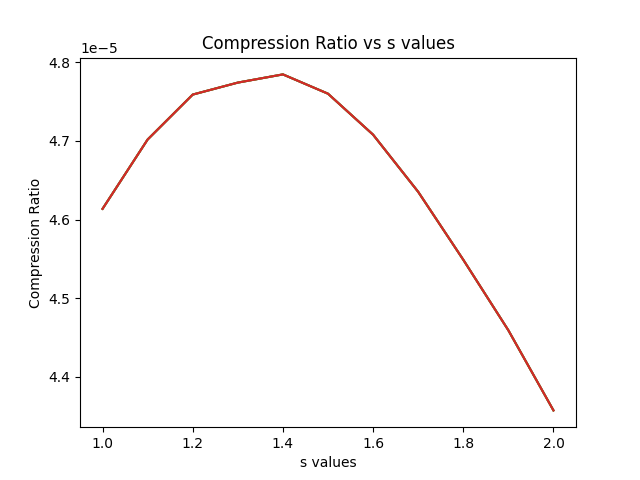

In [12]:
import matplotlib.pyplot as plt
from cued_sf2_lab.dct import regroup
from cued_sf2_lab.laplacian_pyramid import bpp, quantise
step_sizes = [23.4, 24.2, 24.9, 25.4, 25.9, 26.2, 26.4, 26.5, 26.5, 26.5, 26.4]
s_list = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
compression_ratios = []


for s, step_size in zip(np.arange(1.0, 2.1, 0.1), step_sizes):
    Y = lbt(X, s, 8)
    Yq = quantise(Y, step_size)
    Yr = regroup(Yq, 8)/8
    # Zp = undo(Z, s, 8)
    # bit = np.sum(Zp ** 2)
    bit = dctbpp(Yr,8)*Yr.size
    bits_direct = bpp(quantise(X, 17)) * X.size
    

    compression_ratio = bits_direct / bit

    compression_ratios.append(compression_ratio)

# plt.plot(s, compression_ratios)
# plt.xlabel('Step Size (s)')
# plt.ylabel('Compression Ratio')
# plt.title('Compression Ratio vs Step Size')
# plt.show()
# print(s_list)
# print(compression_ratios)
plt.plot(s_list, compression_ratios)
plt.xlabel('s values')
plt.ylabel('Compression Ratio')
plt.title('Compression Ratio vs s values')
plt.show()


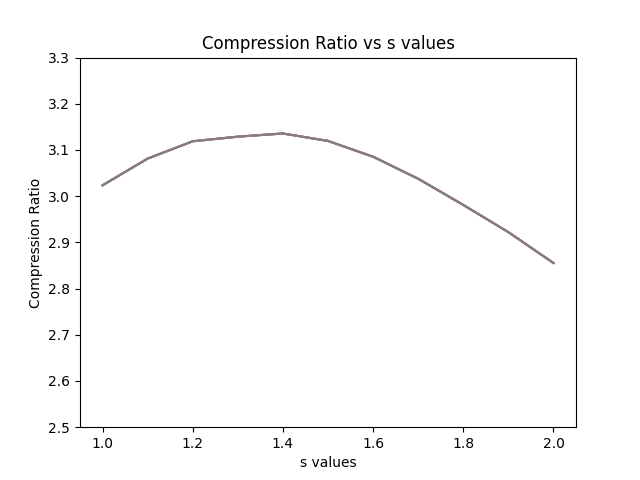

[3.0235686718923427, 3.0814079062355906, 3.1188901047600437, 3.128879030380947, 3.1357242881649863, 3.1196228614343333, 3.0854190197458657, 3.0377548228494393, 2.9810836948654207, 2.922224555981787, 2.8553931446045766]


In [16]:
import matplotlib.pyplot as plt

step_sizes = [23.4, 24.2, 24.9, 25.4, 25.9, 26.2, 26.4, 26.5, 26.5, 26.5, 26.4]
s_list = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
compression_ratios = []

for s, step_size in zip(s_list, step_sizes):
    Y = lbt(X, s, 8)
    Yq = quantise(Y, step_size)
    Yr = regroup(Yq, 8)/8
    bit = dctbpp(Yr,8)
    bits_direct = bpp(quantise(X, 17)) * X.size
    compression_ratio = bits_direct / bit
    compression_ratios.append(compression_ratio)


plt.plot(s_list, compression_ratios)
plt.xlabel('s values')
plt.ylabel('Compression Ratio')
plt.title('Compression Ratio vs s values')
plt.ylim([2.5,3.3])
plt.show()
print(compression_ratios)


In [55]:
def lbt(X, s, N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    t = np.s_[N//2:-N//2]
    Xp = X.copy()
    Xp[t, :] = colxfm(Xp[t, :], Pf)
    Xp[:, t] = colxfm(Xp[:, t].T, Pf).T
    Y = colxfm(colxfm(Xp, C).T, C).T
    return Y

In [9]:
def optimize_step_size(X, N, max_iteration, tol=1e-5):
    C = dct_ii(N)
    s = np.sqrt(2)
    errors = []
    attempted_sizes = np.arange(0, 2560) / 10

    for n in attempted_sizes:
        Y = lbt(X, s, N)
        Yq = quantise(Y, n)
        Z = colxfm(colxfm(Yq.T, C.T).T, C.T)
        X_q = quantise(X, 17)
        err_z = np.std(X - Z)
        err_x = np.std(X_q - X)
        diff = np.abs(err_z - err_x)
        errors.append(diff)
        optimal_step_size = attempted_sizes[np.argmin(errors)]
    return optimal_step_size


In [41]:
print(optimize_step_size(X,N=4,max_iteration=100))

0.3


In [36]:
print(optimize_step_size(X,N=16,max_iteration=100))

0.2


In [42]:
print(optimize_step_size(X,N=8,max_iteration=100))

0.4


In [38]:
s = np.sqrt(2)
Y = lbt(X, np.sqrt(2), 4)
Yq = quantise(Y, 30)
Yr4 = regroup(Yq, 4)/4
bit = dctbpp(Yr4,16)
bits_direct = bpp(quantise(X, 17)) * X.size
compression_ratio4 = bits_direct / bit
print(compression_ratio4)
Zp4 = undo(Yr4, s, 4)


3.6750701134709645


In [39]:
Y = lbt(X, np.sqrt(2), 16)
Yq = quantise(Y, 20)
Yr = regroup(Yq, 16)/16
bit = dctbpp(Yr,16)
bits_direct = bpp(quantise(X, 17)) * X.size
compression_ratio16 = bits_direct / bit
print(compression_ratio16)

2.642328889329818


In [43]:
Y = lbt(X, np.sqrt(2), 8)
Yq = quantise(Y, 40)
Yr = regroup(Yq, 8)/8
bit = dctbpp(Yr,16)
bits_direct = bpp(quantise(X, 17)) * X.size
compression_ratio16 = bits_direct / bit
print(compression_ratio16)

4.934618476497931


The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

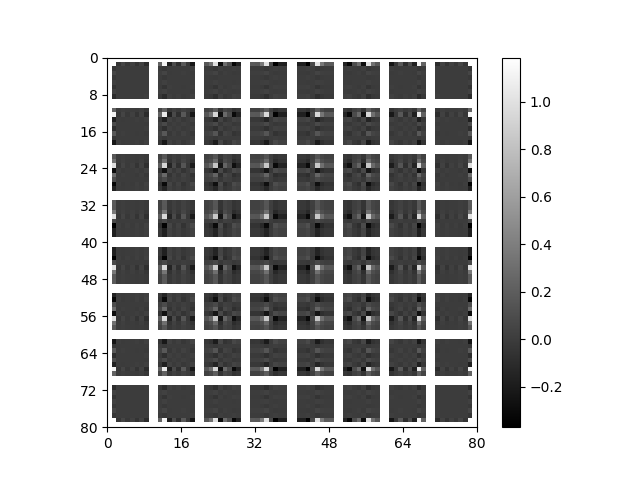

In [10]:
Pf, Pr = pot_ii(8)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

NameError: name 'i' is not defined

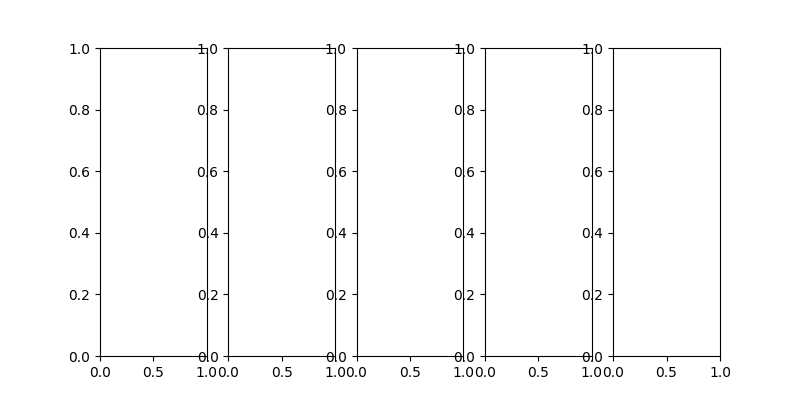

In [18]:
# your code here
scaling_factors = np.arange(1.0, 2.1, 0.2)
fig, axs = plt.subplots(1, 5, figsize=(8, 4))
for s in scaling_factors:
    Pf, Pr = pot_ii(8,s)
    t = np.s_[N//2:-N//2]
    Xp = X.copy()
    Xp[t,:] = colxfm(Xp[t,:],Pf)
    Xp[:,t] = colxfm(Xp[:,t].T,Pf).T
    Xp *= 0.5
    axs[i].imshow(Xp, cmap="gray")
    axs[i].set_title("Xp")

    # Y = colxfm(colxfm(Xp, C8).T, C8).T
    # Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

    # Zp = Z.copy()
    # Zp[:,t] = colxfm(Zp[:,t].T,Pr.T).T
    # Zp[t,:] = colxfm(Zp[t,:],Pr.T)
    # fig, ax = plt.subplots()

# fig, axs = plt.subplots(1, 5, figsize=(8, 4))
# axs[0].imshow(X, cmap="gray")
# axs[0].set_title("X")
# axs[1].imshow(X_q, cmap='gray')
# axs[1].set_title("X_quantised")
# axs[2].imshow(X_q, cmap='gray')
# axs[2].set_title("X_quantised")
# axs[3].imshow(X_q, cmap='gray')
# axs[3].set_title("X_quantised")
# axs[4].imshow(X_q, cmap='gray')
# axs[4].set_title("X_quantised")
# axs[5].imshow(X_q, cmap='gray')
# axs[5].set_title("X_quantised")


# bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
# bases = bases.reshape(-1, 1)
# fig, ax = plt.subplots()
# im_obj = plot_image(bases @ bases.T, ax=ax)
# fig.colorbar(im_obj, ax=ax);

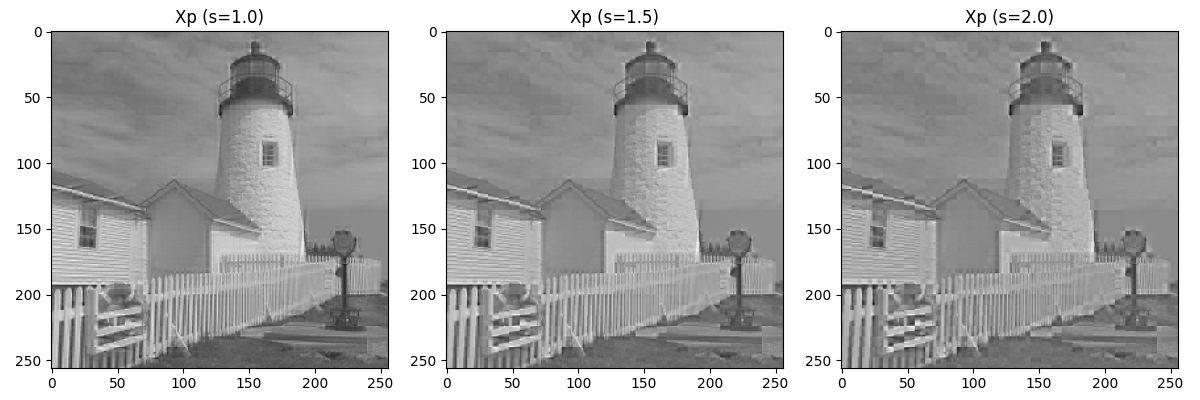

In [11]:
scaling_factors = np.arange(1.0, 2.1, 0.5)
fig, axs = plt.subplots(1, len(scaling_factors), figsize=(12, 4))

for i, s in enumerate(scaling_factors):
    Pf, Pr = pot_ii(8, s)
    t = np.s_[N//2:-N//2]
    Xp = X.copy()
    Xp[t, :] = colxfm(Xp[t, :], Pf)
    Xp[:, t] = colxfm(Xp[:, t].T, Pf).T
    Xp *= 0.5
    axs[i].imshow(Xp, cmap="gray")
    axs[i].set_title("Xp (s={})".format(s))

plt.tight_layout()
plt.show()


With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>

In [12]:
def dctbpp(Yr,N):
    sub_images = Yr.reshape(N,256//N,N,256//N).swapaxes(1,2)
    total_bits = 0
    for i in range(sub_images.shape[0]):
        for j in range(sub_images.shape[1]):
            Ys = sub_images[i][j]
            total_bits += bpp(Ys)*Ys.size
    return total_bits


In [16]:
def optimize_step_size(X, N, max_iteration, tol=1e-5):
    # scaling_factors = np.arange(1.0, 2.1, 0.1)
        C = dct_ii(N)
    # optimal_step_sizes = []

    # for s in scaling_factors:
        errors = []
        attempted_sizes = np.arange(0, 2560) / 10
        s = np.sqrt(2)
        for n in attempted_sizes:
            Y = lbt(X, s, N)
            Yq = quantise(Y, n)
            Z = colxfm(colxfm(Yq.T, C.T).T, C.T)
            Zp = undo(Z,s,N)
            X_q = quantise(X, 17)
            err_z = np.std(X - Zp)
            err_x = np.std(X_q - X)
            diff = np.abs(err_z - err_x)
            errors.append(diff)

        optimal_step_size = np.argmin(errors) + 1
        print(("optimal step size is:",optimal_step_size/10))
     

        return optimal_step_size

In [23]:
def optimize_step_size(X, N, max_iteration, tol=1e-5):
    C = dct_ii(N)
    errors = []
    attempted_sizes = np.arange(0, 2560) / 10
    s = np.sqrt(2)
    for n in attempted_sizes:
        Y = lbt(X, s, N)
        Yq = quantise(Y, n)
        Z = colxfm(colxfm(Yq.T, C.T).T, C.T)
        Zp = undo(Z,s,N)
        X_q = quantise(X, 17)
        err_z = np.std(X - Zp)
        err_x = np.std(X_q - X)
        diff = np.abs(err_z - err_x)
        errors.append(diff)

    optimal_step_size = attempted_sizes[np.argmin(errors)]
     

    return optimal_step_size

In [12]:
C4 = dct_ii(4)
C16 = dct_ii(16)

In [29]:
print(optimize_step_size(X, 4, max_iteration=100, tol=1e-5))

0.3


In [30]:
print(optimize_step_size(X, 16, max_iteration=100, tol=1e-5))

ValueError: colxfm error: height of X not multiple of size of C

In [20]:
errors = []

for n in np.arange(0, 2560)/10:
    s = np.sqrt(2)
    Y = lbt(X, s, 4)
    Yq = quantise(Y, n)
    Z = colxfm(colxfm(Yq.T, C4.T).T, C4.T)
    Zp = undo(Z,s,4)
    X_q = quantise(X, 17)
    err_z = np.std(X - Zp)
    err_x = np.std(X_q - X)
    diff = np.abs(err_z - err_x)
    errors.append(diff)
optimal_step_size = np.argmin(errors) + 1
print(("optimal step size is:",optimal_step_size/10))

('optimal step size is:', 0.4)


In [17]:
print(optimize_step_size(X,N = 4, max_iteration=100))

('optimal step size is:', 0.4)
4


In [ ]:
print(optimize_step_size(X,N = 16, max_iteration=100))

In [22]:
s = np.sqrt(2)
Y = lbt(X, s, 16)
Yq = quantise(Y,0.4)
Yr = regroup(Yq, 16)/16
    # Zp = undo(Z, s, 8)
    # bit = np.sum(Zp ** 2)
bit16 = dctbpp(Yr,16)*Yr.size
bits_direct = bpp(quantise(X, 17)) * X.size
compressionratio = bits_direct / bit16
print(compressionratio)


2.8894505496937902e-05


[3.3630284749393367, 3.3694514274433645, 3.349732774992339]


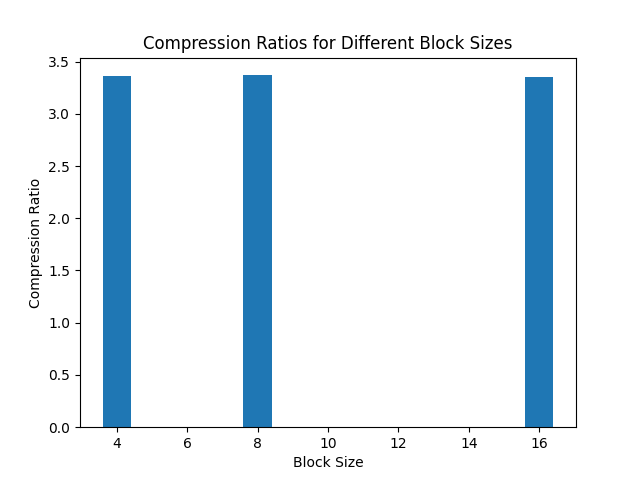

In [11]:
# your code here
def evaluate_lbt_block_sizes(X, scaling_factor):
    block_sizes = [4, 8, 16]
    optimal_step_sizes = []

    for N in block_sizes:
        Y = lbt(X, scaling_factor, N)
        optimal_step = optimize_step_size(Y,N, max_iteration = 100)
        optimal_step_sizes.append(optimal_step)

    return optimal_step_sizes


scaling_factor = 1.414  # Use the previously selected scaling factor
optimal_step_sizes = evaluate_lbt_block_sizes(X, scaling_factor)

compression_ratios = []
for i, block_size in enumerate([4, 8, 16]):
    Yq = quantise(Y, optimal_step_sizes[i])
    Yr = regroup(Yq, (block_size, block_size))
    total_bits = dctbpp(Yr, 16)/16
    compression_ratio = X.size / total_bits
    compression_ratios.append(compression_ratio)

print(compression_ratios)

block_sizes = [4, 8, 16]
plt.bar(block_sizes, compression_ratios)
plt.xlabel("Block Size")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratios for Different Block Sizes")
plt.show()



In [24]:
# from tqdm.auto import tqdm
import numpy as np
def optimise_step_size(Y,N,s):
    Cn = dct_ii(N)
    Xq = quantise(X,17)
    rms_direct = np.std(X-Xq)
    rms_list =[]
    errs = []
    for i in (np.arange(0,1000)/10):
        t = np.s_[N//2:-N//2]
        Pf,Pr = pot_ii(N,s)
        Z = colxfm(colxfm(quantise(Y,i).T,Cn.T).T,Cn.T)
        Zp = Z.copy()
        Zp[:,t]=colxfm(Zp[:,t].T,Pr.T).T
        Zp[t,:]=colxfm(Zp[t,:],Pr.T)
        rms = np.std(X-Zp)
        rms_list.append(rms)
        errs.append(rms-rms_direct)
    ind_opt = np.argmin(np.abs(errs))
    step_size_opt = ind_opt/10
    return step_size_opt, rms_list[ind_opt]


In [25]:
Y4 = lbt(X, np.sqrt(2), 4)

print(optimise_step_size(Y4, 4, np.sqrt(2)))

(28.9, 4.865191809670256)


In [70]:
bit_4 = dctbpp(Y4r,16)
bits_direct = bpp(quantise(X, 17)) * X.size
compression_ratio4 = bits_direct / bit_4
print(compression_ratio4)

3.014864255051902


In [69]:
Y4q = quantise(Y4, 28.9)
Y4r = regroup(Y4q, 16)/16
Z4p = undo(Y4r, np.sqrt(2), 4)


In [71]:
bit_4 = dctbpp(Y4r,16)
bits_direct = bpp(quantise(X, 17)) * X.size
compression_ratio4 = bits_direct / bit_4
print(compression_ratio4)

3.014864255051902


In [35]:
Y16 = lbt(X, np.sqrt(2), 16)
print(optimise_step_size(Y16, 16, np.sqrt(2)))

(22.9, 4.852927110565234)


In [63]:
Y16q = quantise(Y16, 22.9)
Y16r = regroup(Y16q, 16)/16
Z16p = undo(Y16r, np.sqrt(2), 16)

In [66]:
bit_16 = dctbpp(Y16r,16)
bits_direct = bpp(quantise(X, 17)) * X.size
compression_ratio16 = bits_direct / bit_16
print(compression_ratio16)

2.9407971685983316


In [28]:
Y8 = lbt(X, np.sqrt(2), 8)
print(optimise_step_size(Y8, 8, np.sqrt(2)))

(25.9, 4.855072116017472)


In [65]:
bit_8 = dctbpp(Y8r,16)
bits_direct = bpp(quantise(X, 17)) * X.size
compression_ratio8 = bits_direct / bit_8
print(compression_ratio8)

3.4177367095171065


In [60]:
Y8q = quantise(Y8, 25.9)
Y8r = regroup(Y8q, 8)/8
Z8p = undo(Y8r, np.sqrt(2), 8)

In [34]:
# def undo(Z,s,N):
#     Pf, Pr = pot_ii(N, s)
#     C = dct_ii(N)
#     Zp = Z.copy()
#     Zp[:,t] = colxfm(Zp[:,t].T,Pr.T).T
#     Zp[t,:] = colxfm(Zp[t,:],Pr.T)
#     return Zp

In [62]:
def undo(Z, s, N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    t = np.s_[N//2:-N//2]
    Zp = Z.copy()
    Zp[:, t] = colxfm(Zp[:, t].T, Pr.T).T
    Zp[t, :] = colxfm(Zp[t, :], Pr.T)
    Xp = colxfm(colxfm(Zp, C.T).T, C.T)
    return Xp


In [ ]:

Yr = regroup(Yq, 16)/16
Zp = undo(Z, s, 8)

Text(0.5, 1.0, '8-point DCT')

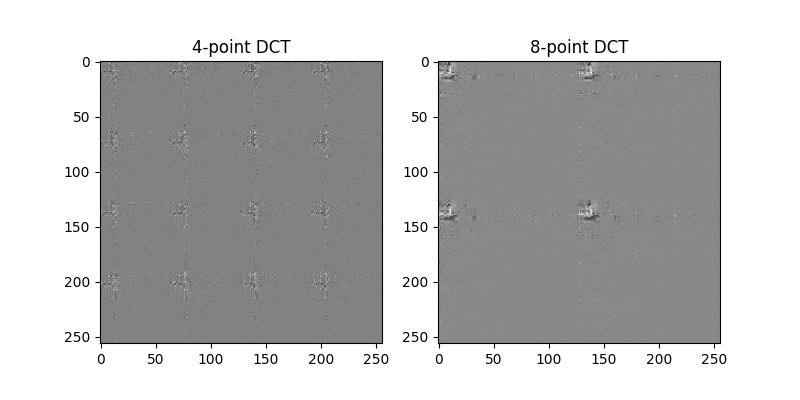

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(Z4p, cmap="gray")
axs[0].set_title(f"4-point DCT")
axs[1].imshow(Z8p, cmap='gray')
axs[1].set_title(f"8-point DCT")


In [54]:
def undo(Z,s,N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    Zp = Z.copy()
    Zp[:,t] = colxfm(Zp[:,t].T,Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:],Pr.T)
    return Zp
